# Download dataset

## Download from Google Drive


In [ ]:
# https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99
# https://drive.google.com/file/d/1kySNos1iSDQZUjqJZPV69cDGEYFaKhM1/view?usp=sharing

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kySNos1iSDQZUjqJZPV69cDGEYFaKhM1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1kySNos1iSDQZUjqJZPV69cDGEYFaKhM1" -O data-science-bowl-2018.zip && rm -rf /tmp/cookies.txt

## Unpacking dataset

In [ ]:
!ls
!unzip data-science-bowl-2018.zip -d data

## Unpacking the neccessary data

In [ ]:
!unzip data/stage1_train.zip -d data/train
!unzip data/stage1_test.zip -d data/test

# Work with dataset

## Main definition

Add libs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import random
import glob

Define constants

In [ ]:
DIR_TRAIN = 'data/train/'
DIR_TEST = 'data/test/'

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT)
IMG_INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

In [ ]:
IMG_INPUT_SHAPE

(256, 256, 3)

## Get the data

In [ ]:
train_dataset = glob.glob(DIR_TRAIN + '*')
test_dataset = glob.glob(DIR_TEST + '*')

In [ ]:
print('Train images: ', len(train_dataset))
print('Test images: ', len(test_dataset))

Train images:  670
Test images:  65


## Define main function to get image, generate batch, etc ...

In [ ]:
def get_image(sample_dir, shape=IMG_SHAPE, color=1):
  path = sample_dir + '/images/' + sample_dir.split('/')[-1] + '.png'
  image =  cv2.imread(path, color)
  return cv2.resize(image, shape) if shape else image

In [ ]:
def get_mask(sample_dir, shape=IMG_SHAPE, color=0):
  all_masks = glob.glob(sample_dir + '/masks/*')
  image_mask = cv2.imread(all_masks[0], color)
  for mask in all_masks[1:]:
    image_mask = np.maximum(image_mask, cv2.imread(mask, color))
  return cv2.resize(image_mask, shape) if shape else image_mask

In [ ]:
def data_train_generator(all_data_dirs, batch_size):
  while True:
    x_batch = []
    y_batch = []
    for i in range(batch_size):
      sample = random.choice(all_data_dirs)
      x_batch += [get_image(sample)]
      y_batch += [get_mask(sample)]
    x_batch = np.array(x_batch) / 255.
    y_batch = np.array(y_batch) / 255.
    yield x_batch, np.expand_dims(y_batch, -1)

## Let's display some images

In [ ]:
sample_dir = random.choice(train_dataset)

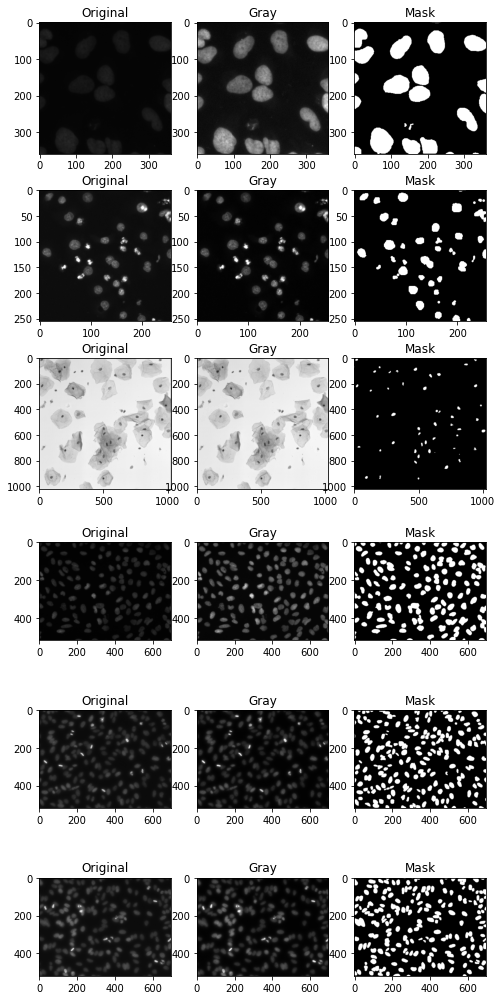

In [ ]:
display_items = 6

fig, axes = plt.subplots(nrows=display_items, ncols=3, figsize=(8, display_items*3))

for i in range(display_items):

  sample_dir = random.choice(train_dataset)
  
  sample_image_color = get_image(sample_dir, None, 1)
  sample_image_gray = get_image(sample_dir, None, 0)
  sample_mask = get_mask(sample_dir, None, 0)
  
  axes[i, 0].imshow(sample_image_color)
  axes[i, 0].set_title('Original')
  axes[i, 1].imshow(sample_image_gray / 255, cmap='gray')
  axes[i, 1].set_title('Gray')
  axes[i, 2].imshow(sample_mask / 255, cmap='gray')
  axes[i, 2].set_title('Mask')

plt.show()

Test our train image generator

In [ ]:
for x, y in data_train_generator(train_dataset, 16):
    break
ix = random.randint(0, 15)

In [ ]:
print(x.shape)
print(y.shape)

(16, 256, 256, 3)
(16, 256, 256, 1)


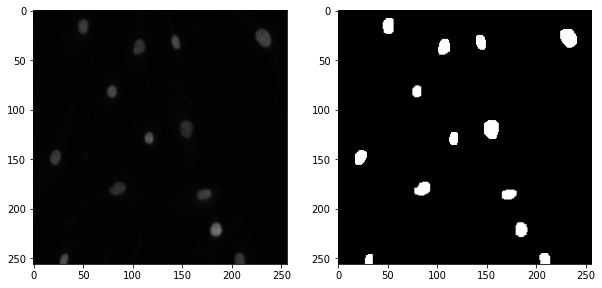

In [ ]:
ix = random.randint(0, 15)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axes[0].imshow(x[ix])
axes[1].imshow(y[ix][..., 0], cmap='gray')
plt.show()

# Neural Network

In [ ]:
import keras
from keras import backend as K

from keras.models import Model
from keras.layers import Input, Activation, Dense
from keras.layers import Concatenate, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

## Model

Unet CNN Neural Network for semantic segmentation

In [ ]:
inp = Input(shape=IMG_INPUT_SHAPE)

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = Concatenate()([conv_4_2, up_1])

conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_3_2, up_2])

conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_2_2, up_3])

conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)



up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_1_2, up_4])
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)


model = Model(inputs=inp, outputs=result)

## Dice coefficient

In [ ]:
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))

## Compile

In [ ]:
best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                save_freq=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                save_freq=1)


callbacks = [best_w, last_w]

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = [dice_coef])

## Fit

In [ ]:
BATCH_SIZE = 16
STEPS_PER_EPOCH = 32
EPOCHS = 16

VALIDATION_BATCH_SIZE = 8
VALIDATION_STEPS = 4

In [22]:
model.fit(
  data_train_generator(train_dataset, BATCH_SIZE),
  steps_per_epoch=STEPS_PER_EPOCH,
  epochs=EPOCHS,
  verbose=1,
  callbacks=callbacks,
  validation_data=data_train_generator(train_dataset, VALIDATION_BATCH_SIZE),
  validation_steps=VALIDATION_STEPS,
)

Epoch 1/16
32/32 [==============================] - 35s 1s/step - loss: 0.5575 - dice_coef: 0.1750 - val_loss: 0.3264 - val_dice_coef: 0.1677
Epoch 2/16
32/32 [==============================] - 36s 1s/step - loss: 0.2893 - dice_coef: 0.2904 - val_loss: 0.2156 - val_dice_coef: 0.4547
Epoch 3/16
32/32 [==============================] - 33s 1s/step - loss: 0.2392 - dice_coef: 0.4317 - val_loss: 0.2314 - val_dice_coef: 0.5025
Epoch 4/16
32/32 [==============================] - 36s 1s/step - loss: 0.1749 - dice_coef: 0.5915 - val_loss: 0.1158 - val_dice_coef: 0.7094
Epoch 5/16
32/32 [==============================] - 34s 1s/step - loss: 0.1253 - dice_coef: 0.7192 - val_loss: 0.1263 - val_dice_coef: 0.7434
Epoch 6/16
32/32 [==============================] - 38s 1s/step - loss: 0.1113 - dice_coef: 0.7625 - val_loss: 0.0858 - val_dice_coef: 0.7905
Epoch 7/16
32/32 [==============================] - 38s 1s/step - loss: 0.0953 - dice_coef: 0.7932 - val_loss: 0.0769 - val_dice_coef: 0.8076
Epoch 

# Predictions

## Let's see some predictions (Results)

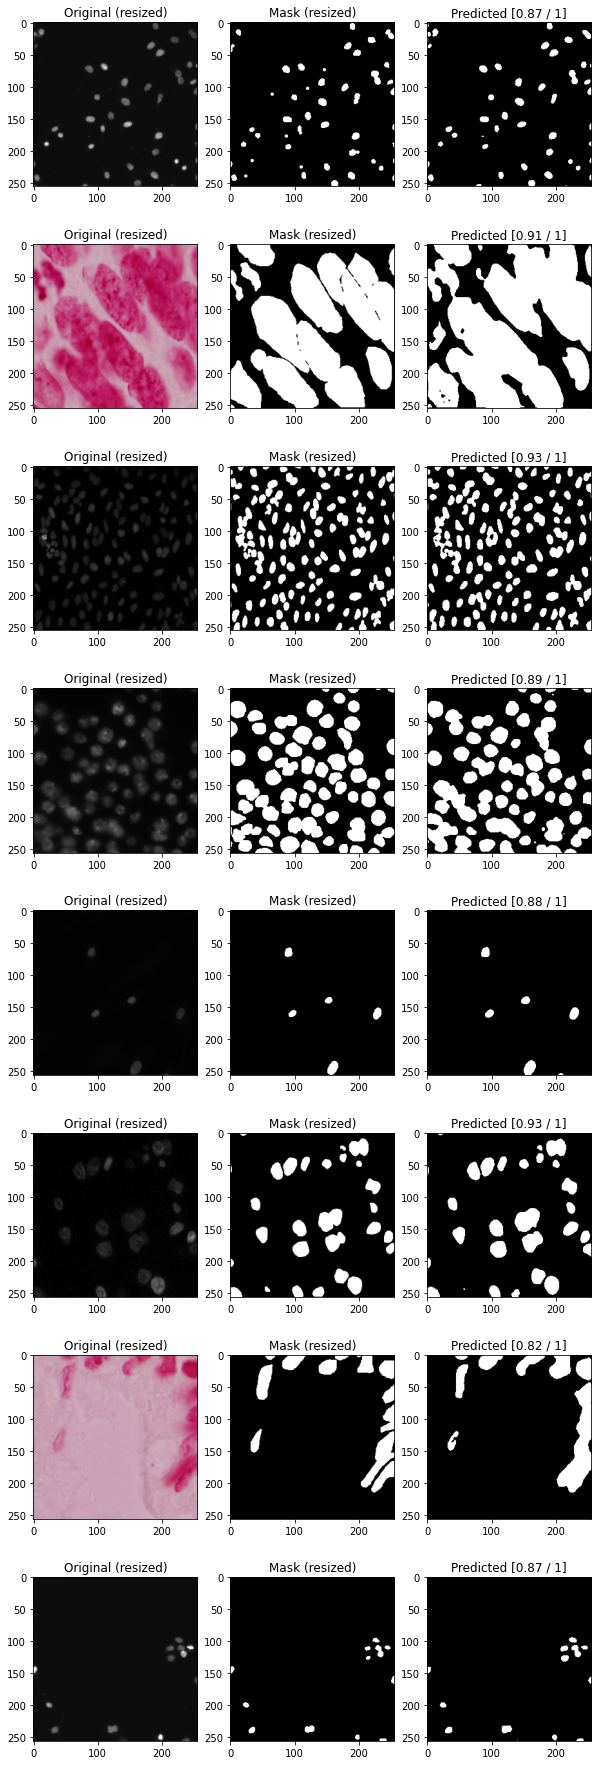

In [23]:
num = 8

for x, y in data_train_generator(train_dataset, num):
    break

preds = (model.predict(x) > 0.5).astype(np.uint8)
fig, axes = plt.subplots(nrows=num, ncols=3, figsize=(10, 32))

for i in range(len(x)):

  mask = y[i][..., 0]
  pred = preds[i][..., 0]

  dice = round(np.sum(mask[pred==1])*2.0 / (np.sum(mask) + np.sum(pred)),2)

  axes[i, 0].imshow(x[i])
  axes[i, 0].set_title('Original (resized)')
  axes[i, 1].imshow(mask, cmap='gray')
  axes[i, 1].set_title('Mask (resized)')
  axes[i, 2].imshow(pred, cmap='gray')
  axes[i, 2].set_title(f'Predicted [{dice} / 1]')

plt.show()

Run all train images on our model

In [24]:
res_names = []
res_dices = []

for item in train_dataset:
  img = get_image(item) / 255
  mask = get_mask(item) / 255
  pred = model.predict(np.array([img]))
  pred = (pred[0] > 0.5).astype(np.uint8).reshape((256, 256))
  dice = np.sum(mask[pred==1])*2.0 / (np.sum(mask) + np.sum(pred))
  res_names += [item]
  res_dices += [dice]

In [25]:
results_train = {
    'image_path': res_names,
    'dice score': res_dices
}

In [26]:
df_results_train = pd.DataFrame(data=results_train)

In [27]:
df_results_train.describe()

,dice score
count,670.000000
mean,0.877210
std,0.139803
min,0.000000
25%,0.864954
50%,0.907541
75%,0.944798
max,0.982857


Looks like we have some outlier

In [28]:
outlier = res_names[res_dices.index(0.0)]
print(outlier)

data/train/7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80


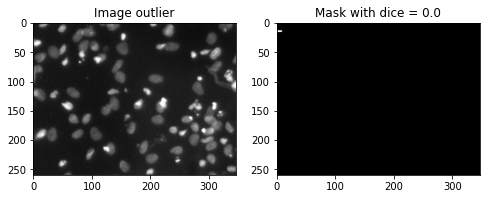

In [29]:
sample_image_color = get_image(outlier, None, 1)
sample_mask = get_mask(outlier, None, 0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
axes[0].imshow(sample_image_color / 255)
axes[0].set_title('Image outlier')
axes[1].imshow(sample_mask / 255, cmap='gray')
axes[1].set_title('Mask with dice = 0.0')

plt.show()

# Test data

Let's predict random image from test dataset

In [30]:
item = random.choice(test_dataset)
image = get_image(item)
image.shape

(256, 256, 3)

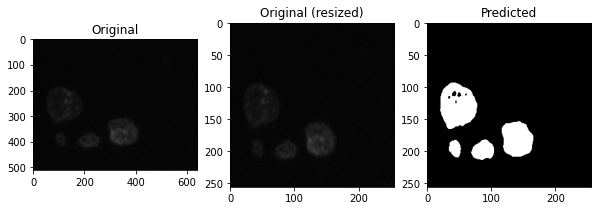

In [31]:
item = random.choice(test_dataset)
image_orig = get_image(item, shape=None)
image = get_image(item) / 255

preds = (model.predict(np.array([image])) > 0.5).astype(np.uint8)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

pred = preds[0][..., 0]

#dice = round(np.sum(mask[pred==1])*2.0 / (np.sum(mask) + np.sum(pred)),2)

axes[0].imshow(image_orig)
axes[0].set_title('Original')
axes[1].imshow(image)
axes[1].set_title('Original (resized)')
axes[2].imshow(pred, cmap='gray')
axes[2].set_title(f'Predicted')

plt.show()

looks good :)

In [32]:
!mkdir model

In [33]:
with open('model/model.json', 'w') as file:
  file.write(model.to_json())

model.save_weights(filepath='model/model_weights.h5', overwrite=True, save_format=None, options=None)